# 프로젝트: Seq2Seq로 한-영 번역기 만들기

## 목차:  
STEP 0. 패키지 & 데이터 로드  
STEP 1. EDA & 데이터 전처리  
STEP 2. 모델 설계  
STEP 3. 모델 학습  
STEP 4. 시각화 & 결과 해석  
회고

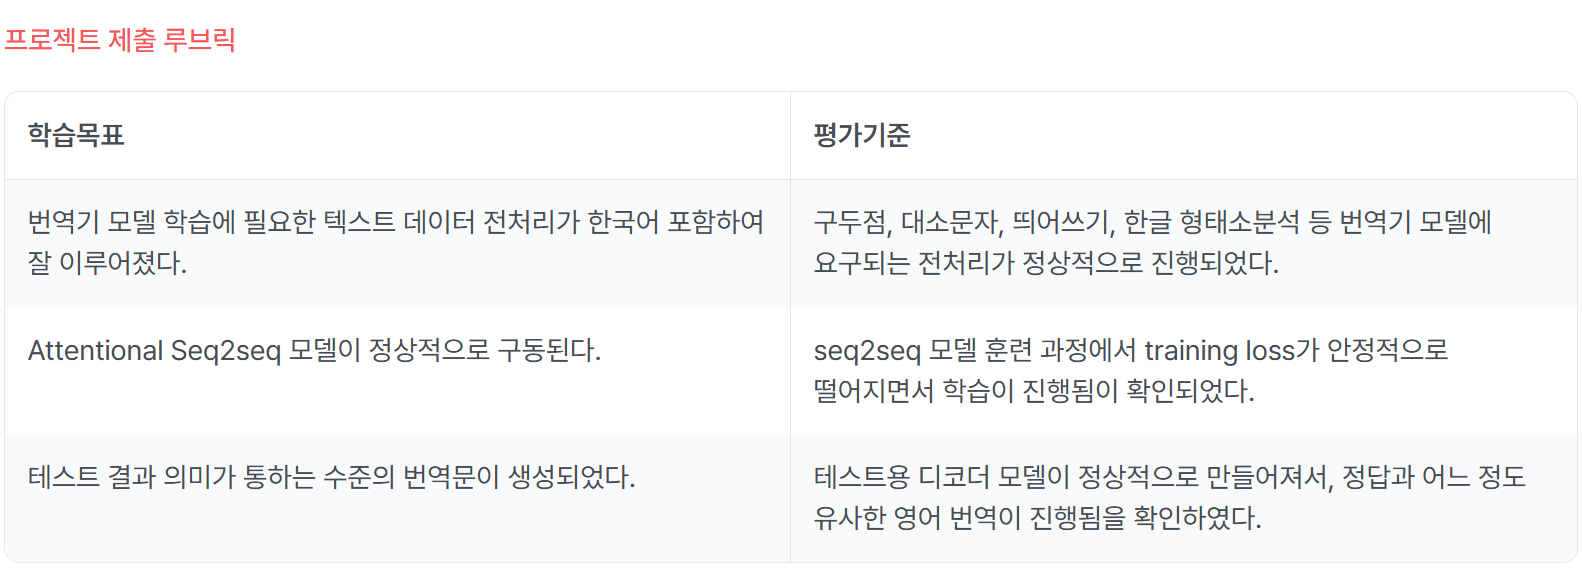

# STEP 0. 라이브러리 & 데이터 로드

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 폰트 설정

In [1]:
!sudo apt-get install -y fonts-nanum
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib

# 폰트 등록
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
matplotlib.rc('font', family='NanumGothic')

# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


## 사용할 라이브러리

In [2]:
import os
import re
import urllib.request
import zipfile
import sentencepiece as spm
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.__version__)

2.9.0+cu126


## 데이터 로드

In [3]:
%cd "/content/drive/MyDrive/Colab Notebooks/아이펠/AIFFEL_quest_rs/GoingDeeper/GD04"

/content/drive/MyDrive/Colab Notebooks/아이펠/AIFFEL_quest_rs/GoingDeeper/GD04


In [4]:
dataset_dir = "./data/kor-eng/kor-eng"
path_to_file = os.path.join(dataset_dir, "kor.txt")

print("데이터셋 디렉토리:", os.listdir(dataset_dir))
print("한글 데이터 파일 경로:", path_to_file)

데이터셋 디렉토리: ['kor.txt']
한글 데이터 파일 경로: ./data/kor-eng/kor-eng/kor.txt


# STEP 1. EDA & 전처리

In [5]:
# 샘플 확인
df = pd.read_csv(path_to_file,
                 sep = "\t",
                 names = ["eng", "kor", "attribution"]).drop(columns=["attribution"])
df.head()

,eng,kor
0,Go.,가.
1,Hi.,안녕.
2,Run!,뛰어!
3,Run.,뛰어.
4,Who?,누구?


## EDA

In [6]:
# 중복 확인
print(df.duplicated().sum())

# 결측치 확인
print(df.isna().sum())

0
eng    0
kor    0
dtype: int64



=== 길이 통계 ===
      eng_len_char  kor_len_char
0                3             2
1                3             3
2                4             3
3                4             3
4                4             3
...            ...           ...
6376           127            61
6377           142            63
6378           161            82
6379           262           111
6380           537           296

[6381 rows x 2 columns]


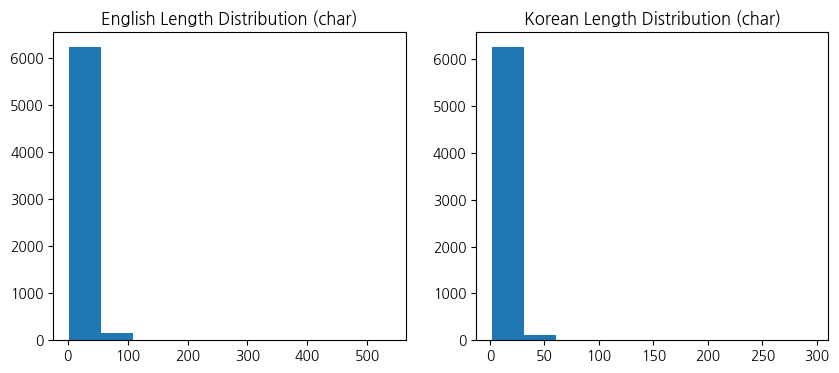

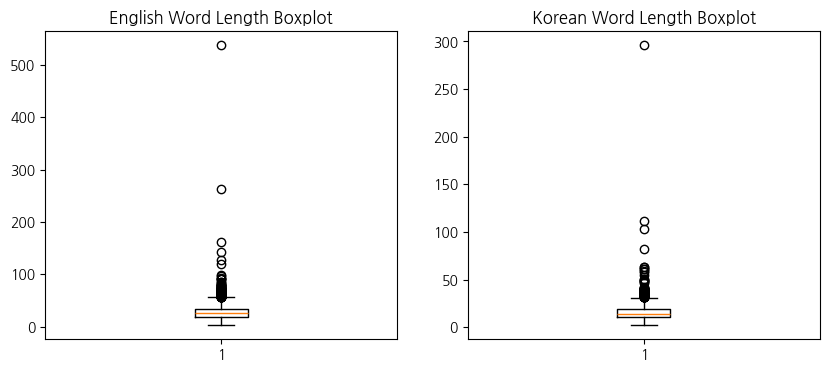



=== 중복 개수 ===
영어 문장 중복: 678
한국어 문장 중복: 314


=== 특수문자/문장부호 종류 ===
영어 문장에서 등장한 특수문자: ['!', '"', '$', '%', "'", ',', '-', '.', ':', ';', '?', '°']
한국어 문장에서 등장한 특수문자: ['!', '"', '%', '(', ')', ',', '-', '.', '/', ':', '?', '~', '°']
전체에서 등장한 특수문자: ['!', '"', '$', '%', "'", '(', ')', ',', '-', '.', '/', ':', ';', '?', '~', '°']


In [7]:
# 복사본 생성
df_copy = df.copy()

# ---------------------------
# 1. 길이 통계
# ---------------------------
df_copy["eng_len_char"] = df_copy["eng"].str.len()
df_copy["kor_len_char"] = df_copy["kor"].str.len()

print("\n=== 길이 통계 ===")
print(df_copy[["eng_len_char", "kor_len_char"]])

# 히스토그램
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(df_copy["eng_len_char"])
plt.title("English Length Distribution (char)")

plt.subplot(1,2,2)
plt.hist(df_copy["kor_len_char"])
plt.title("Korean Length Distribution (char)")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.boxplot(df_copy["eng_len_char"])
plt.title("English Word Length Boxplot")

plt.subplot(1,2,2)
plt.boxplot(df_copy["kor_len_char"])
plt.title("Korean Word Length Boxplot")
plt.show()

# ---------------------------
# 2. 중복
# ---------------------------
print("\n\n=== 중복 개수 ===")
print("영어 문장 중복:", df_copy["eng"].duplicated().sum())
print("한국어 문장 중복:", df_copy["kor"].duplicated().sum())


# ---------------------------
# 3. 특수문자/문장부호 분석
# ---------------------------
def extract_special_chars(series):
    # 시리즈 전체 문자열 합치기
    all_text = " ".join(series)

    # 단어(\w)와 공백(\s)을 제외한 모든 문자 = 특수문자/문장부호
    specials = re.findall(r"[^\w\s]", all_text)

    # 중복 제거 + 정렬
    return sorted(set(specials))


eng_specials = extract_special_chars(df["eng"])
kor_specials = extract_special_chars(df["kor"])
all_specials = sorted(set(eng_specials + kor_specials))

print("\n\n=== 특수문자/문장부호 종류 ===")
print("영어 문장에서 등장한 특수문자:", eng_specials)
print("한국어 문장에서 등장한 특수문자:", kor_specials)
print("전체에서 등장한 특수문자:", all_specials)

### **EDA 결과**
---

### **1. 중복 처리**

(1) 문장 부호 빼면 똑같은 행들  

예시:
```
Run!	뛰어!
Run.	뛰어.
```
해결 방법:  
1. 문장 부호 모두 제거 후 중복 행 제거
    - 뉘앙스가 사라져서 번역기 성능이 낮아질 수 있음
2. 그대로 두기
    - 학습 효율이 떨어질 것 같음  
  
<br>

(2) 영어 원문 하나에 한국어 표현 여러 개  

예시:
```
Wait!   기다려!
Wait!   잠깐!
```
해결 방법:  
1. 영어 기준 하나만 남기기  
    - (1)과 마찬가지로 다양한 의미를 포함하지 못해 번역기 성능이 낮아질 수 있음  
2. 그대로 두기  
    - 이것 역시 학습 효율이 떨어질 것 같음
<br>

(1), (2) 모두 일단 그대로 두는 것을 baseline으로 하고 추가 실험을 진행해 보는 방법이 괜찮아 보임.  
<br>

---
### **2. 시퀀스 길이**  

시퀀스 길이 분포를 보니 극단적인 이상치가 존재함. 따라서
1. 토큰화 후 토큰 길이의 분포를 다시 확인  
2. 최대 길이 max_length 지정  
3. max_length에 맞춰서 토큰화된 시퀀스를 cut  
4. padding  

순서로 진행할 것.


## 전처리

### text 전처리

In [8]:
# 전처리 함수 정의
def preprocess_text(text):
    """
    텍스트 전처리 함수
    """
    if pd.isna(text):
        return ""

    text = str(text)

    # 1. 소문자화
    text = text.lower()

    # 2. 반복되는 문장 부호 제거 (2개 이상 → 1개)
    text = re.sub(r'([.!?,])\1+', r'\1', text)

    # 3. 영어/숫자/한글/문장부호만 남기고 모두 삭제
    # 이모지, 이모티콘, 특수문자 자동 제거
    text = re.sub(r"[^가-힣a-zA-Z0-9\s.!?,']", " ", text)

    # 4. 문장부호 앞뒤로 공백 추가
    text = re.sub(r'([.!?,])', r' \1 ', text)

    # 5. 연속 공백을 하나의 공백으로 교체
    text = re.sub(r'\s+', ' ', text)

    # 6. 앞뒤 공백 제거
    text = text.strip()

    return text

In [9]:
df["eng"] = df["eng"].apply(preprocess_text)
df["kor"] = df["kor"].apply(preprocess_text)

df.head()

,eng,kor
0,go .,가 .
1,hi .,안녕 .
2,run !,뛰어 !
3,run .,뛰어 .
4,who ?,누구 ?


In [10]:
# 파일 저장
df["eng"].to_csv("eng_corpus.txt", index=False, header=False, sep="\n", encoding="utf-8")
df["kor"].to_csv("kor_corpus.txt", index=False, header=False, sep="\n", encoding="utf-8")

print("파일 저장 완료: eng_corpus.txt, kor_corpus.txt")

파일 저장 완료: eng_corpus.txt, kor_corpus.txt


### 토큰화

In [11]:
vocab_size = 2000
pad_id = 0
bos_id = 1
eos_id = 2
unk_id = 3

# 1. 영어 모델 학습
spm.SentencePieceTrainer.train(
    input='eng_corpus.txt',
    model_prefix='encoder_spm',
    vocab_size=vocab_size,
    pad_id=pad_id,
    bos_id=bos_id,
    eos_id=eos_id,
    unk_id=unk_id
)

# 2. 한국어 모델 학습
spm.SentencePieceTrainer.train(
    input='kor_corpus.txt',
    model_prefix='decoder_spm',
    vocab_size=vocab_size,
    pad_id=pad_id,
    bos_id=bos_id,
    eos_id=eos_id,
    unk_id=unk_id
)

print("SentencePiece 모델 학습 완료!")

SentencePiece 모델 학습 완료!


In [12]:
# SentencePiece 모델 로드
encoder_tokenizer = spm.SentencePieceProcessor()
encoder_tokenizer.load("encoder_spm.model") # 영어

decoder_tokenizer = spm.SentencePieceProcessor()
decoder_tokenizer.load("decoder_spm.model") # 한국어

True

In [13]:
# 샘플로 인코딩, 디코딩 확인
eng_sample = df["eng"][5000]
spa_sample = df["kor"][5000]
print(eng_sample)
print(spa_sample)

# bos, eos 토큰 추가
enc_token = encoder_tokenizer.encode(eng_sample)
enc_token = [encoder_tokenizer.bos_id()] + enc_token + [encoder_tokenizer.eos_id()]
print("\n인코딩 토큰:", enc_token)

# 위 토큰을 디코딩하면?
enc_decoding = encoder_tokenizer.decode(enc_token)
print("디코딩 토큰:", enc_decoding)

i'm glad that you're back in boston .
네가 보스턴으로 돌아와서 기쁘다 .

인코딩 토큰: [1, 6, 7, 22, 888, 25, 20, 11, 7, 45, 233, 28, 79, 140, 4, 2]
디코딩 토큰: i'm glad that you're back in boston .


영어 최대 길이: 167
한국어 최대 길이: 176
영어 평균 길이: 9.21
한국어 평균 길이: 9.75
------------------------------
상위 90% 길이 -> 영어: 14 | 한국어: 15
상위 95% 길이 -> 영어: 16 | 한국어: 17
상위 99% 길이 -> 영어: 21 | 한국어: 22
상위 99.9% 길이 -> 영어: 32 | 한국어: 38


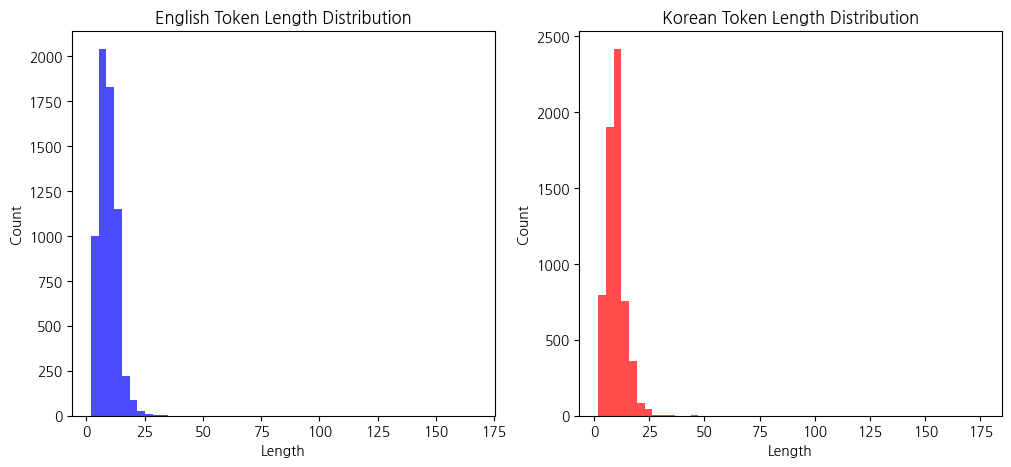

In [14]:
# 토큰화 후 데이터 분포 확인

# df_copy 전처리
df_copy["eng"] = df_copy["eng"].apply(preprocess_text)
df_copy["kor"] = df_copy["kor"].apply(preprocess_text)

# 2. 전체 데이터 토큰화 및 길이 계산
# encode_as_ids: 텍스트를 정수 시퀀스로 변환
df_copy['eng_sp_ids'] = df_copy['eng'].apply(lambda x: encoder_tokenizer.encode_as_ids(str(x)))
df_copy['kor_sp_ids'] = df_copy['kor'].apply(lambda x: decoder_tokenizer.encode_as_ids(str(x)))

# 길이 계산
df_copy['eng_sp_len'] = df_copy['eng_sp_ids'].apply(len)
df_copy['kor_sp_len'] = df_copy['kor_sp_ids'].apply(len)

# 3. 통계 정보 출력
print(f"영어 최대 길이: {df_copy['eng_sp_len'].max()}")
print(f"한국어 최대 길이: {df_copy['kor_sp_len'].max()}")
print(f"영어 평균 길이: {df_copy['eng_sp_len'].mean():.2f}")
print(f"한국어 평균 길이: {df_copy['kor_sp_len'].mean():.2f}")

# 4. 백분위수(Percentile) 확인 (중요!)
# 90%, 95%, 99%에 해당하는 길이를 확인합니다.
print("-" * 30)
for per in [90, 95, 99, 99.9]:
    eng_len = np.percentile(df_copy['eng_sp_len'], per)
    kor_len = np.percentile(df_copy['kor_sp_len'], per)
    print(f"상위 {per}% 길이 -> 영어: {int(eng_len)} | 한국어: {int(kor_len)}")

# 5. 시각화 (히스토그램)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df_copy['eng_sp_len'], bins=50, alpha=0.7, color='blue')
plt.title('English Token Length Distribution')
plt.xlabel('Length')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(df_copy['kor_sp_len'], bins=50, alpha=0.7, color='red')
plt.title('Korean Token Length Distribution')
plt.xlabel('Length')
plt.ylabel('Count')

plt.show()

특수 토큰들을 포함해서 max_lenth=40 정도만 해도 전체 데이터의 99.9%를 커버할 수 있기 때문에,  
최대 길이는 40으로 지정한다.  

---

ablation study n.12: 35로 수정

### 데이터로더

In [16]:
class TranslationDataset(Dataset):
    def __init__(self, data, encoder_tokenizer, decoder_tokenizer, max_len):
        self.data = data
        self.encoder_tokenizer = encoder_tokenizer
        self.decoder_tokenizer = decoder_tokenizer
        self.max_len = max_len
        self.pad_id = encoder_tokenizer.pad_id()
        self.bos_id = encoder_tokenizer.bos_id()
        self.eos_id = encoder_tokenizer.eos_id()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # 데이터 로드 (혹시 모를 비문자열 방지를 위해 str 변환)
        src_text = str(self.data.iloc[idx]['eng'])
        trg_text = str(self.data.iloc[idx]['kor'])

        # 1. 토큰화 (IDs로 변환)
        src_ids = self.encoder_tokenizer.encode_as_ids(src_text)
        trg_ids = self.decoder_tokenizer.encode_as_ids(trg_text)

        # 2. 최대 길이 제한 (Special Token 공간 확보를 위해 미리 자름)
        # Encoder: [Text] + [EOS] -> 1개 공간 필요
        # Decoder: [SOS] + [Text] + [EOS] -> 2개 공간 필요 (하지만 입/출력을 쪼개므로 각각 1개씩)

        if len(src_ids) > self.max_len - 1:
            src_ids = src_ids[:self.max_len - 1]

        if len(trg_ids) > self.max_len - 2: # SOS, EOS 고려해서 -2
            trg_ids = trg_ids[:self.max_len - 2]

        # 3. Special Token 추가
        # Encoder 입력에도 EOS 추가
        enc_input = src_ids + [self.eos_id]

        # Decoder Input(SOS시작) vs Label(EOS끝) 분리
        dec_input = [self.bos_id] + trg_ids
        dec_label = trg_ids + [self.eos_id]

        # 4. Padding
        # Encoder Padding
        enc_padding_len = self.max_len - len(enc_input)
        if enc_padding_len > 0:
            enc_input = enc_input + [self.pad_id] * enc_padding_len

        # Decoder Padding (Input과 Label 길이를 동일하게 맞춰야 함)
        dec_padding_len = self.max_len - len(dec_input)
        if dec_padding_len > 0:
            dec_input = dec_input + [self.pad_id] * dec_padding_len
            dec_label = dec_label + [self.pad_id] * dec_padding_len

        # 5. 텐서 변환 (LongTensor가 정수형 인덱스에 적합, 가독성)
        return {
            'src': torch.tensor(enc_input, dtype=torch.long),
            'trg_input': torch.tensor(dec_input, dtype=torch.long),
            'trg_label': torch.tensor(dec_label, dtype=torch.long)
        }

In [35]:
train_ratio = 0.8
MAX_LEN = 35
BATCH_SIZE = 32

train_data = df.sample(frac=train_ratio, random_state=42)
valid_data = df.drop(train_data.index)

train_data.reset_index(drop=True, inplace=True)
valid_data.reset_index(drop=True, inplace=True)

train_data = TranslationDataset(train_data, encoder_tokenizer, decoder_tokenizer, max_len=MAX_LEN)
validataion_data = TranslationDataset(valid_data, encoder_tokenizer, decoder_tokenizer, max_len=MAX_LEN)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validataion_data, batch_size=BATCH_SIZE, shuffle=False)

In [36]:
# Shape 확인
for batch in train_loader:
    src = batch['src']
    trg_input = batch['trg_input']
    trg_label = batch['trg_label']

    print(f"Src Shape: {src.shape}")
    print(f"Trg Input Shape: {trg_input.shape}")
    print(f"Trg Label Shape: {trg_label.shape}")
    break

Src Shape: torch.Size([32, 35])
Trg Input Shape: torch.Size([32, 35])
Trg Label Shape: torch.Size([32, 35])


# STEP 2. 모델 설계
각각 1개의 GRU를 갖는 Encoder-Decoder 구조를 설계할 것이다.  

용어 정리:  
- Q = s_{t-1} = 이전 시점의 디코더 hidden state
- K, V = 인코더 모든 시점의 hidden state = H
- alignment score = Q, K 가중합을 tanh에 넣고 v 곱한 값
    - v = 스칼라로 만들기 위해 곱하는 learnable vector
- attention distribute = attetion weight = softmax(alignment score)
- attention value = context vector = sum(H * attention weight)

In [37]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()

        self.W1 = nn.Linear(hidden_dim*2, hidden_dim) # 양방향 적용했으니 차원*2
        self.W2 = nn.Linear(hidden_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs, mask): # mask 인자 추가
        # hidden: (batch_size, hidden_dim)
        # encoder_outputs: (src_len, batch_size, hidden_dim)

        src_len = encoder_outputs.shape[0]

        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)  # (batch_size, src_len, hidden_dim)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)  # (batch_size, src_len, hidden_dim)

        energy = torch.tanh(self.W1(encoder_outputs) + self.W2(hidden))  # (batch_size, src_len, hidden_dim)
        attention = self.v(energy).squeeze(2)  # (batch_size, src_len)

        # === 마스킹 적용 ===
        # mask가 0인 부분(패딩)은 매우 작은 숫자로 채워 softmax 결과가 0이 되게 한다.
        attention = attention.masked_fill(mask == 0, -1e10)

        return nn.functional.softmax(attention, dim=1)  # (batch_size, src_len)


class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, dropout_ratio=0.2):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.dropout = nn.Dropout(dropout_ratio) # 드롭아웃 층 추가

        # 수정: 양방향 학습
        self.rnn = nn.GRU(emb_dim, hidden_dim, bidirectional=True)
        # 양방향이기 때문에 마지막 h가 두 개 나옴 (정방향 끝, 역방향 끝)
        # 이걸 하나로 합치기 위해 fc 레이어로 선형변환 해줌
        self.fc = nn.Linear(hidden_dim * 2, hidden_dim)

    def forward(self, src):
        # src : (src_len, batch_size)
        embedded = self.dropout(self.embedding(src))  # embedded : (src_len, batch_size, emb_dim)
        outputs, hidden = self.rnn(embedded)  # outputs : (src_len, batch_size, hidden_dim)
        # outputs: 인코더 전체 시점의 hidden state들 -> 디코더 입력으로 사용
        # hidden: 인코더 마지막 시점의 hidden state -> 디코더의 입력(맨 처음 hidden state)으로 사용

        # 정방향/역방향 Hidden State 결합 및 압축
        # hidden[-2]: 정방향 마지막 상태, hidden[-1]: 역방향 마지막 상태
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))

        return outputs, hidden.unsqueeze(0)


class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, attention, dropout_ratio=0.2):
        super(Decoder, self).__init__()

        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.dropout = nn.Dropout(dropout_ratio) # 드롭아웃 층 추가

        # === 기존 ===
        # Decoder RNN에는 embedding만 입력
        # self.rnn = nn.GRU(emb_dim, hidden_dim)
        # === 수정 ===
        # embedding만 받는 게 아니라, (embedding + context vector)를 받으므로 차원도 수정
        # context vector의 크기는 hidden_dim의 2배 -> 인코더가 양방향이므로
        self.rnn = nn.GRU(emb_dim + hidden_dim * 2, hidden_dim)

        # 출력층에는 hidden state와 context vector(attention value)가 결합되어 입력
        # 방금 입력으로 들어온 단어 임베딩도 입력(emb_dim)하면 좋다. (정보 손실 최소화)
        # 인코더 양방향 h 2개 + 디코더 h = 3개
        self.fc_out = nn.Linear(emb_dim + hidden_dim * 3, output_dim)

    def forward(self, input, hidden, encoder_outputs, mask): # mak 인자 추가
        # input : (batch_size,) -> 단어 1개
        # hidden : (batch_size, hidden_dim) -> 이전 Hidden State
        # encoder_outputs : (src_len, batch_size, hidden_dim)
        input = input.unsqueeze(0)  # input : (1, batch_size)
        embedded = self.dropout(self.embedding(input))  # embedded : (1, batch_size, emb_dim)

        # attention weight 계산. decoder의 이전 hidden state, s_{t-1}와 encoder의 H가 입력된다.
        a = self.attention(hidden[-1], encoder_outputs, mask)  # a : (batch_size, src_len)
        a = a.unsqueeze(1)  # a : (batch_size, 1, src_len)

        # H에 가중치를 부여해 attention value(Context vector) 계산
        # 즉, a(=attention weight)와 인코더 output(=H)을 내적해서 context vector 구하기 (위와 같은 말임)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)  # encoder_outputs : (batch_size, src_len, hidden_dim)
        context = torch.bmm(a, encoder_outputs)  # context : (batch_size, 1, hidden_dim)
        context = context.permute(1, 0, 2)  # context : (1, batch_size, hidden_dim)

        # === 기존 ===
        # output, hidden = self.rnn(embedded, hidden)

        # === 수정 ===
        # 위에서는 rnn 인풋으로 embedded 한 개만 들어갔음 (self.rnn(embedded, hidden))
        # 근데 그게 아니라 embedded + context vector 가 들어가야 함
        # 그래야 context vector를 이용하면서 문맥 파악 가능
        output, hidden = self.rnn(torch.cat((embedded, context), dim=2), hidden)

        # 그리고 fc 레이어 입력도 (embedded + hidden + context)로
        # 기존(hidden + context)에다가 embedded 추가
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        context = context.squeeze(0)

        prediction = self.fc_out(torch.cat((output, context, embedded), dim=1))

        return prediction, hidden, a.squeeze(1)


class Seq2SeqAttention(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg=None, teacher_forcing_ratio=0.5, max_len=MAX_LEN, bos_id = 1, eos_id=2):
        # 학습 모드에서는 trg_len 사용, 추론 모드에서는 max_len까지 동적 생성
        batch_size = src.shape[1]

        # 조기 종료를 위해 tensor가 아닌 리스트 사용
        outputs = []

        # 시각화를 위해 attention 저장
        attentions = []

        # encoder_outputs: H
        # hidden: Encoder(Bi-GRU) → FC Layer(압축) → hidden (문장 전체의 맥락을 포함) → Decoder 초기 상태
        encoder_outputs, hidden = self.encoder(src)

        # === 마스크 생성 (src에서 패딩이 아닌 곳은 1, 패딩은 0) ===
        mask = (src != pad_id).permute(1,0)

        if trg is not None:
            input = trg[0, :]
            trg_len = trg.shape[0]
            for t in range(1, trg_len):
                # 아래의 input은 단방향일 때보다 2배의 정보를 갖고있음
                output, hidden, attention = self.decoder(input, hidden, encoder_outputs, mask)
                outputs.append(output.unsqueeze(0))
                attentions.append(attention.unsqueeze(0))
                # teacher forcing 추가
                teacher_force = random.random() < teacher_forcing_ratio
                top1 = output.argmax(1)
                input = trg[t] if teacher_force else top1

        else:
		    # inference에서는 target(정답)이 없기 때문에 sos_token을 생성해줍니다.
            input = torch.full((batch_size,), bos_id, dtype=torch.long, device=self.device)
            finished = torch.zeros(batch_size, dtype=torch.bool, device=self.device)

            for t in range(max_len):
                output, hidden, attention = self.decoder(input, hidden,  encoder_outputs, mask)
                outputs.append(output.unsqueeze(0))
                attentions.append(attention.unsqueeze(0))
                top1 = output.argmax(1)
                input = top1

                # 조기 종료 조건
                finished |= (top1 == eos_id)
                if finished.all():
                    break

        outputs = torch.cat(outputs, dim=0)  # (trg_len, batch_size, output_dim)
        attentions = torch.cat(attentions, dim=0)  # (trg_len, batch_size, src_len)

        return outputs, attentions

모델 정의

In [68]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = len(encoder_tokenizer)
output_dim = len(decoder_tokenizer)
emb_dim = 64
hid_dim = 128

encoder = Encoder(input_dim, emb_dim, hid_dim).to(device)
attention = BahdanauAttention(hid_dim).to(device)
decoder = Decoder(output_dim, emb_dim, hid_dim, attention).to(device)
model = Seq2SeqAttention(encoder, decoder, device).to(device)

print(device)
print(model)

cuda
Seq2SeqAttention(
  (encoder): Encoder(
    (embedding): Embedding(2000, 64)
    (dropout): Dropout(p=0.2, inplace=False)
    (rnn): GRU(64, 128, bidirectional=True)
    (fc): Linear(in_features=256, out_features=128, bias=True)
  )
  (decoder): Decoder(
    (attention): BahdanauAttention(
      (W1): Linear(in_features=256, out_features=128, bias=True)
      (W2): Linear(in_features=128, out_features=128, bias=True)
      (v): Linear(in_features=128, out_features=1, bias=False)
    )
    (embedding): Embedding(2000, 64)
    (dropout): Dropout(p=0.2, inplace=False)
    (rnn): GRU(320, 128)
    (fc_out): Linear(in_features=448, out_features=2000, bias=True)
  )
)


# STEP 3. 모델 학습

## (1) Optimizer & Loss

In [69]:
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=pad_id)

# 스케줄러 정의
# validation loss가 2번(patience=2) 연속 안 줄어들면 학습률을 절반(factor=0.5)으로 깎음
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

## (2) train_step

In [70]:
def train_step(model, data_loader, optimizer, criterion, epoch, device, teacher_forcing_ratio=0.5):
    model.train()
    epoch_loss = 0

    progress_bar = tqdm(data_loader, desc=f"Epoch {epoch+1} [Train]", leave=False)

    for batch in progress_bar:
        # [배치, 길이] -> [길이, 배치]로 변경 (Transpose)
        src = batch['src'].to(device).transpose(0, 1)
        trg_input = batch['trg_input'].to(device).transpose(0, 1)
        trg_label = batch['trg_label'].to(device).transpose(0, 1)

        optimizer.zero_grad()

        # 모델 입력
        outputs, _ = model(src, trg_input, teacher_forcing_ratio=teacher_forcing_ratio)

        # 차원 변환: [길이 * 배치, 단어장크기]
        trg_label = trg_label[:-1]
        outputs = outputs.reshape(-1, outputs.shape[-1])

        # 정답도 [길이 * 배치]로 펼침
        trg_label = trg_label.reshape(-1)

        loss = criterion(outputs, trg_label)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    return epoch_loss / len(data_loader)

## (3) eval_step

In [71]:
def eval_step(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for batch in data_loader:
            # 여기도 마찬가지로 [배치, 길이] -> [길이, 배치]로 변경
            src = batch['src'].to(device).transpose(0, 1)
            trg_input = batch['trg_input'].to(device).transpose(0, 1)
            trg_label = batch['trg_label'].to(device).transpose(0, 1)

            # 모델 입력
            outputs, _ = model(src, trg_input, teacher_forcing_ratio=0.0)

            # 차원 변환
            trg_label = trg_label[:-1]
            outputs = outputs.reshape(-1, outputs.shape[-1])
            trg_label = trg_label.reshape(-1)

            loss = criterion(outputs, trg_label)

            epoch_loss += loss.item()

    return epoch_loss / len(data_loader)

## (4) Early stop

In [72]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): 성능이 개선되지 않아도 참을 Epoch 수
            verbose (bool): 로그 출력 여부
            delta (float): 개선되었다고 인정할 최소 변화량
            path (str): 베스트 모델 저장 경로
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## (5) 모델 학습

In [67]:
%%time

EPOCHS = 50
patience = 5
early_stopping = EarlyStopping(patience=patience, verbose=True, path='best_seq2seq_model.pt')

# Loss 기록을 위한 리스트 선언
train_losses = []
valid_losses = []

for epoch in range(EPOCHS):
    # 학습
    train_loss = train_step(model, train_loader, optimizer, criterion, epoch, device)

    # 검증
    valid_loss = eval_step(model, validation_loader, criterion, device)

    # 매 Epoch마다 Validation Loss를 보고 학습률 조정
    scheduler.step(valid_loss)

    # 기록 저장
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}')

    # early stop 체크 (여기서 모델 저장도 자동으로 수행됨)
    early_stopping(valid_loss, model)

    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

KeyboardInterrupt: 

In [73]:
%%time

EPOCHS = 50
patience = 5
early_stopping = EarlyStopping(patience=patience, verbose=True, path='best_seq2seq_model.pt')

# Teacher Forcing Scheduling 설정
# 10 Epoch 동안 1.0에서 0.0으로 선형적으로 줄어듦
DECAY_EPOCHS = 10

train_losses = []
valid_losses = []

for epoch in range(EPOCHS):
    # [핵심] Teacher Forcing Ratio 동적 계산
    # 초반엔 1.0(정답 다 보여줌) -> 점차 줄여서 -> 나중엔 0.0(혼자 풀기)
    # epoch 0: 1.0, epoch 10: 0.5, epoch 20~: 0.0
    teacher_forcing_ratio = max(0.0, 1.0 - (epoch / DECAY_EPOCHS))

    # 학습 (계산된 ratio 전달)
    train_loss = train_step(model, train_loader, optimizer, criterion, epoch, device, teacher_forcing_ratio)

    # 검증
    valid_loss = eval_step(model, validation_loader, criterion, device)

    # 매 Epoch마다 Validation Loss를 보고 학습률 조정
    scheduler.step(valid_loss)

    # 기록 저장
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'Epoch {epoch+1}/{EPOCHS} | TF Ratio: {teacher_forcing_ratio:.2f} | Train Loss: {train_loss:.4f} | Val Loss: {valid_loss:.4f}')

    # early stop 체크
    early_stopping(valid_loss, model)

    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

Epoch 1/50 | TF Ratio: 1.00 | Train Loss: 5.0478 | Val Loss: 5.6575
Validation loss decreased (inf --> 5.657508).  Saving model ...


Epoch 2/50 | TF Ratio: 0.90 | Train Loss: 4.3457 | Val Loss: 5.2160
Validation loss decreased (5.657508 --> 5.215994).  Saving model ...


Epoch 3/50 | TF Ratio: 0.80 | Train Loss: 4.1231 | Val Loss: 4.9822
Validation loss decreased (5.215994 --> 4.982200).  Saving model ...


Epoch 4/50 | TF Ratio: 0.70 | Train Loss: 4.0037 | Val Loss: 4.8463
Validation loss decreased (4.982200 --> 4.846263).  Saving model ...


Epoch 5/50 | TF Ratio: 0.60 | Train Loss: 3.9361 | Val Loss: 4.7522
Validation loss decreased (4.846263 --> 4.752168).  Saving model ...


Epoch 6/50 | TF Ratio: 0.50 | Train Loss: 3.8900 | Val Loss: 4.6215
Validation loss decreased (4.752168 --> 4.621549).  Saving model ...


Epoch 7/50 | TF Ratio: 0.40 | Train Loss: 3.8038 | Val Loss: 4.5446
Validation loss decreased (4.621549 --> 4.544600).  Saving model ...


Epoch 8/50 | TF Ratio: 0.30 | Train Loss: 3.7796 | Val Loss: 4.4835
Validation loss decreased (4.544600 --> 4.483455).  Saving model ...


Epoch 9/50 | TF Ratio: 0.20 | Train Loss: 3.7588 | Val Loss: 4.3940
Validation loss decreased (4.483455 --> 4.393954).  Saving model ...


Epoch 10/50 | TF Ratio: 0.10 | Train Loss: 3.7101 | Val Loss: 4.3525
Validation loss decreased (4.393954 --> 4.352545).  Saving model ...


Epoch 11/50 | TF Ratio: 0.00 | Train Loss: 3.6256 | Val Loss: 4.3194
Validation loss decreased (4.352545 --> 4.319424).  Saving model ...


Epoch 12/50 | TF Ratio: 0.00 | Train Loss: 3.5024 | Val Loss: 4.2743
Validation loss decreased (4.319424 --> 4.274344).  Saving model ...


Epoch 13/50 | TF Ratio: 0.00 | Train Loss: 3.3843 | Val Loss: 4.3156
EarlyStopping counter: 1 out of 5


Epoch 14/50 | TF Ratio: 0.00 | Train Loss: 3.2838 | Val Loss: 4.2692
Validation loss decreased (4.274344 --> 4.269168).  Saving model ...


Epoch 15/50 | TF Ratio: 0.00 | Train Loss: 3.1789 | Val Loss: 4.2616
Validation loss decreased (4.269168 --> 4.261567).  Saving model ...


Epoch 16/50 | TF Ratio: 0.00 | Train Loss: 3.0902 | Val Loss: 4.2641
EarlyStopping counter: 1 out of 5


Epoch 17/50 | TF Ratio: 0.00 | Train Loss: 3.0099 | Val Loss: 4.2787
EarlyStopping counter: 2 out of 5


Epoch 18/50 | TF Ratio: 0.00 | Train Loss: 2.9263 | Val Loss: 4.2702
EarlyStopping counter: 3 out of 5


Epoch 19/50 | TF Ratio: 0.00 | Train Loss: 2.7571 | Val Loss: 4.2650
EarlyStopping counter: 4 out of 5


Epoch 20/50 | TF Ratio: 0.00 | Train Loss: 2.6973 | Val Loss: 4.2941
EarlyStopping counter: 5 out of 5
Early stopping triggered!
CPU times: user 6min 38s, sys: 2.4 s, total: 6min 41s
Wall time: 6min 48s


# STEP 5. 시각화 & 결과 해석

In [81]:
# Load Best Model
model.load_state_dict(torch.load('best_seq2seq_model_15.pt'))
print("Best model loaded!")

Best model loaded!


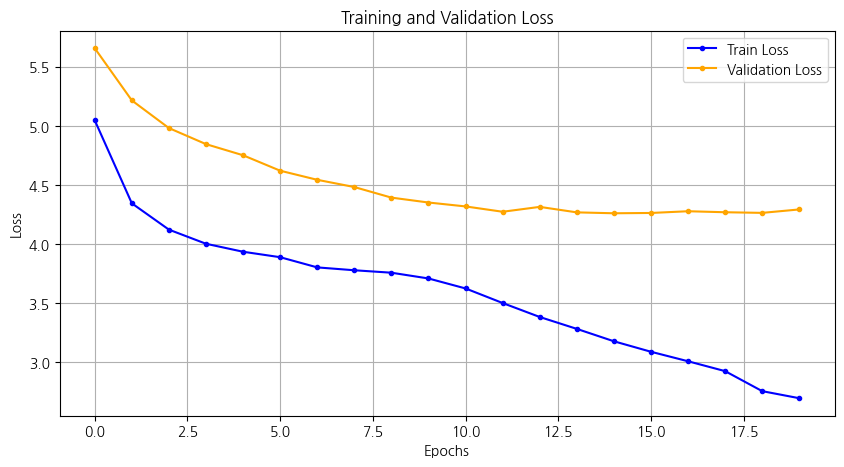

In [82]:
# loss 커브 그래프
def plot_loss_curve(train_losses, valid_losses):
    plt.figure(figsize=(10, 5))

    plt.plot(train_losses, label='Train Loss', color='blue', marker='.')
    plt.plot(valid_losses, label='Validation Loss', color='orange', marker='.')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

plot_loss_curve(train_losses, valid_losses)

In [83]:
def evaluate(sentence, model, encoder_tokenizer, decoder_tokenizer, max_len=MAX_LEN):
    model.eval()

    sentence = preprocess_text(sentence)
    src_ids = encoder_tokenizer.encode(sentence)
    src_ids = src_ids[:max_len]
    src_ids = src_ids + [0] * (max_len - len(src_ids))  # 패딩 추가
    src_tensor = torch.tensor(src_ids).unsqueeze(1).to(device)  # (src_len, 1)

    # 실제 EOS 토큰 문자열 가져오기 (</s>)
    eos_string = decoder_tokenizer.id_to_piece(decoder_tokenizer.eos_id())

    with torch.no_grad():
        outputs, attentions = model(src_tensor, max_len=max_len)

    # 결과 디코딩
    # argmax로 나온 인덱스를 문자로 변환
    decoded_tokens = [decoder_tokenizer.id_to_piece(token.item()) for token in outputs.argmax(2).squeeze(1)]

    result = []
    for token in decoded_tokens:
        if token == eos_string: # 토크나이저에서 가져온 EOS와 비교
            break
        result.append(token)

    # SentencePiece의 _(언더바)를 공백으로 바꾸고 문자열로 합치기
    final_sentence = "".join(result).replace(" ", " ").strip()

    return final_sentence, sentence, attentions.squeeze(1).cpu().numpy()

In [85]:
def plot_attention(attention, sentence, predicted_sentence):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticks(range(len(sentence)))
    ax.set_xticklabels(sentence, fontdict=fontdict, rotation=90)

    ax.set_yticks(range(len(predicted_sentence)))
    ax.set_yticklabels(predicted_sentence, fontdict=fontdict)

    plt.show()

In [86]:
def translate(sentence, model, encoder_tokenizer, decoder_tokenizer, max_len=MAX_LEN):
    result, sentence, attention = evaluate(sentence, model, encoder_tokenizer, decoder_tokenizer, max_len)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    # Attention 크기 조정 (trg_len, src_len)
    attention = attention[:len(result), :len(sentence.split())]

    plot_attention(attention, sentence.split(), result)

Input: the most powerful man all over the world .
Predicted translation: ▁그의▁그의▁▁▁에서▁▁▁▁다▁.▁.▁.


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


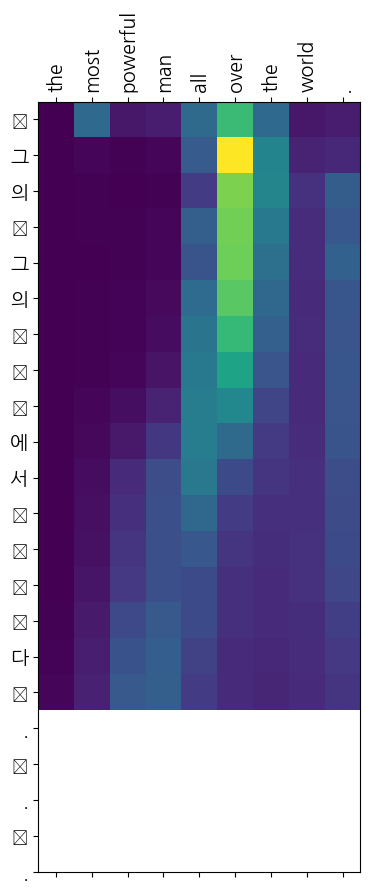

In [87]:
translate("The most powerful man all over the world.", model, encoder_tokenizer, decoder_tokenizer, max_len=MAX_LEN)

Input: may i help you ?
Predicted translation: ▁도와드릴드릴드릴▁?▁?▁?▁?▁?▁?▁?▁?▁?▁?▁?


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


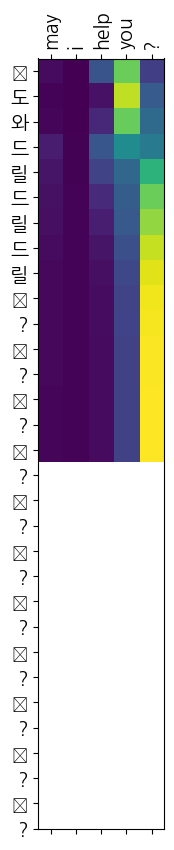

In [88]:
translate("May I help you?", model, encoder_tokenizer, decoder_tokenizer, max_len=MAX_LEN)

Input: can i have some coffee ?
Predicted translation: ▁커피▁▁▁▁▁▁수▁?▁?▁?▁?▁?▁?▁?▁?


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


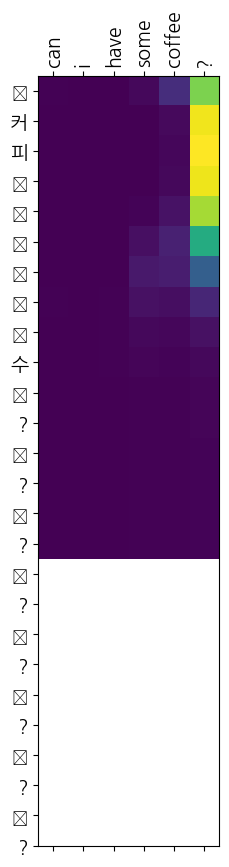

In [89]:
translate("Can I have some coffee?", model, encoder_tokenizer, decoder_tokenizer, max_len=MAX_LEN)